## An example workflow for D3D

A D3D workflow using local ECMWF data.

In [ ]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import pyPoseidon
import pyPoseidon.model as pm
import datetime
from pyPoseidon.utils import data,point
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pyPoseidon.__version__

In [ ]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import cartopy.crs as ccrs


hv.notebook_extension('bokeh')
#hv.notebook_extension('matplotlib')

### Define case

In [56]:
#define in a dictionary the properties of the model..
dic={'minlon':-35., # lat/lon window
     'maxlon':42.,
     'minlat':25.05,
     'maxlat':76.5,
     'solver':'d3d',
     'tag':'eur01',
     'resolution':0.1, #grid resoltuion 
     'step':60, # step for output of map field in d3d
     'rstep': 60*12 ,  # step for restart file
     'start_date':'2010-2-1 0:0:0',
     'time_frame':'12H',
#     'end_date':'2013-2-5 0:0:0',
     'ft1':0, # initial forecasting hour per file
     'ft2':11, # final forecasting hour per file
     'meteo':'ecmwf_oper',
     'dem': 'gebco',
     'dpath' : '/Users/brey/DATA/GEBCO_2014_2D.nc',
     'epath':'/Users/brey/DELFT3D/SVN/7545/bin/lnx64/', #folder for solver executables
     'ncores': 4 , #number of cores
     'rpath':'/Users/brey/Downloads/EUR/D3D/20100201.00/', #location of calc folder
     'Dt':1.0, # add any additional relevant setup variable,
     'conda_bin' : '/Users/brey/miniconda3/bin', #optional conda bin path
     'conda_env': 'mpi3', # optional conda env for the solver
     'ofilename': '/Users/brey/DATA/thomas.txt'#,
    # 'update':[] # optional list of components to be updated
    }

#### Local operational ECMWF files

In [57]:
if 'time_frame' in dic.keys(): 
    end_date= pd.to_datetime(dic['start_date']) + pd.to_timedelta(dic['time_frame'])
    dic.update({'end_date':end_date.strftime(format='%Y-%m-%d %H:%M:%S')})

In [58]:
dic['end_date']

'2010-02-01 12:00:00'

In [59]:
# FOR FORECAST - SINGLE FILE
dr = [pd.to_datetime(dic['start_date'])]
dr

[Timestamp('2010-02-01 00:00:00')]

In [60]:
#FOR USING THE OPTIMUM METEO
dr = pd.date_range(dic['start_date'],dic['end_date'], freq='12H')
dr

DatetimeIndex(['2010-02-01 00:00:00', '2010-02-01 12:00:00'], dtype='datetime64[ns]', freq='12H')

In [61]:
#creating a sequence of folder from which we read the meteo.

PATH='/Users/brey/DATA/'#Path to meteo files
#PATH = '/Volumes/data/projects/CRITECH/meteo/ECMWF/operational/'
folders = [datetime.datetime.strftime(x, '%Y%m%d.%H') for x in dr]
meteo_files = [PATH+'{:04d}/{:02d}/{:02d}/'.format(x.year,x.month,x.day)+datetime.datetime.strftime(x, '%Y%m%d.%H')+'.tropical_cyclone.grib' for x in dr]
meteo_files

['/Users/brey/DATA/2010/02/01/20100201.00.tropical_cyclone.grib',
 '/Users/brey/DATA/2010/02/01/20100201.12.tropical_cyclone.grib']

#### update dictionary

In [62]:
dic.update({'mpaths':meteo_files})

## Initialize

In [63]:
#initialize a model
b = pm.model(**dic)

### set it up

In [64]:
b.set(**dic) #set it up 


extracting dem from /Users/brey/DATA/GEBCO_2014_2D.nc

.. interpolating on grid ..

dem done
boundary files not set..

extracting meteo from /Users/brey/DATA/2010/02/01/20100201.00.tropical_cyclone.grib

retrieving msl at 2010-02-01 00:00:00

retrieving 10u at 2010-02-01 00:00:00

retrieving 10v at 2010-02-01 00:00:00

retrieving msl at 2010-02-01 03:00:00

retrieving 10u at 2010-02-01 03:00:00

retrieving 10v at 2010-02-01 03:00:00

retrieving msl at 2010-02-01 06:00:00

retrieving 10u at 2010-02-01 06:00:00

retrieving 10v at 2010-02-01 06:00:00

retrieving msl at 2010-02-01 09:00:00

retrieving 10u at 2010-02-01 09:00:00

retrieving 10v at 2010-02-01 09:00:00

extracting meteo from /Users/brey/DATA/2010/02/01/20100201.12.tropical_cyclone.grib

retrieving msl at 2010-02-01 12:00:00

retrieving 10u at 2010-02-01 12:00:00

retrieving 10v at 2010-02-01 12:00:00

meteo done


In [65]:
b.impl.meteo.impl.uvp

<xarray.Dataset>
Dimensions:    (latitude: 370, longitude: 552, time: 5, x: 370, y: 552)
Coordinates:
  * latitude   (latitude) float64 24.81 24.95 25.09 25.23 25.37 25.51 25.65 ...
  * longitude  (longitude) float64 -35.3 -35.16 -35.02 -34.88 -34.73 -34.59 ...
  * time       (time) datetime64[ns] 2010-02-01 2010-02-01T03:00:00 ...
Dimensions without coordinates: x, y
Data variables:
    u10        (time, latitude, longitude) float64 2.86 2.963 2.983 2.939 ...
    v10        (time, latitude, longitude) float64 -10.43 -10.44 -10.47 ...
    msl        (time, latitude, longitude) float64 1.014e+05 1.014e+05 ...
    lons       (x, y) float64 -35.3 -35.16 -35.02 -34.88 -34.73 -34.59 ...
    lats       (x, y) float64 24.81 24.81 24.81 24.81 24.81 24.81 24.81 ...

#### Optional adjust the wet area based on a coastline shapefile

In [66]:
b.impl.dem.impl.adjust('/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_50m_coastline.shp',nc=50,ncores=4) 


optimize grid


INFO:pp:Creating server instance (pp-1.6.6)
INFO:pp:Running on Python 2.7.15 darwin
INFO:pp:pp local server started with 8 workers
INFO:pp:Task 0 started
INFO:pp:Task 1 started
INFO:pp:Task 2 started
INFO:pp:Task 3 started



eliminate isolated wet regions

... adjusting ...

... adjusting ...

... adjusting ...

... adjusting ...

... adjusting ...

done 

resample bathymetry

done 


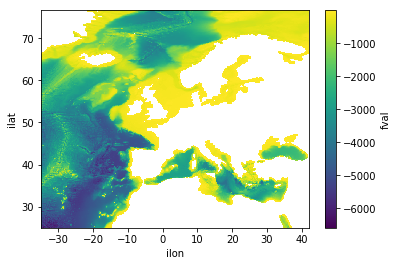

In [67]:
b.impl.dem.impl.Dataset.fval.plot()# test coverage

## Save to folder for execution 

In [68]:
#set the run by saving the files
b.output()

In [69]:
# save model info for further use
b.save()

In [70]:
# save all matrices for further use
#b.pickle(path=path)

In [71]:
dic

{'Dt': 1.0,
 'conda_bin': '/Users/brey/miniconda3/bin',
 'conda_env': 'mpi3',
 'dem': 'gebco',
 'dpath': '/Users/brey/DATA/GEBCO_2014_2D.nc',
 'end_date': '2010-02-01 12:00:00',
 'epath': '/Users/brey/DELFT3D/SVN/7545/bin/lnx64/',
 'ft1': 0,
 'ft2': 11,
 'maxlat': 76.5,
 'maxlon': 42.0,
 'meteo': 'ecmwf_oper',
 'minlat': 25.05,
 'minlon': -35.0,
 'mpaths': ['/Users/brey/DATA/2010/02/01/20100201.00.tropical_cyclone.grib',
  '/Users/brey/DATA/2010/02/01/20100201.12.tropical_cyclone.grib'],
 'ncores': 4,
 'ofilename': '/Users/brey/DATA/thomas.txt',
 'resolution': 0.1,
 'rpath': '/Users/brey/Downloads/EUR/D3D/20100201.00/',
 'rstep': 720,
 'solver': 'd3d',
 'start_date': '2010-2-1 0:0:0',
 'step': 60,
 'tag': 'eur01',
 'time_frame': '12H'}

### execute

In [72]:
#execute
b.run()

MPI process number 001 has host unknown and is running on processor Raven.local
MPI process number 003 has host unknown and is running on processor Raven.local
MPI process number 000 has host unknown and is running on processor Raven.local
MPI process number 002 has host unknown and is running on processor Raven.local
--------------------------------------------------------------------------------
       Deltares, FLOW2D3D Version 6.02.13.8578, Apr 16 2018, 11:35:48
       libflow2d3d.so entry Flow2D3D::Run
--------------------------------------------------------------------------------

Part I    - Initialisation Time Dep. Data module...    
            runid : eur01
Part II   - Creating intermediate files...             
Part III  - Initialisation of the Execution module...  
Part IV   - Reading complete MD-file...                     
Part V    - Initialisation & checking input...              
Part VI   - Initialisation & checking second part...        
Part VII  - Initialisation o

  Time to finish   2m 53s,   14.7% completed, time steps left  614
  Time to finish   2m 53s,   14.9% completed, time steps left  613
  Time to finish   2m 53s,   15.0% completed, time steps left  612
  Time to finish   2m 52s,   15.1% completed, time steps left  611
  Time to finish   2m 52s,   15.3% completed, time steps left  610
  Time to finish   2m 52s,   15.4% completed, time steps left  609
  Time to finish   2m 51s,   15.6% completed, time steps left  608
  Time to finish   2m 51s,   15.7% completed, time steps left  607
  Time to finish   2m 51s,   15.8% completed, time steps left  606
  Time to finish   2m 50s,   16.0% completed, time steps left  605
  Time to finish   2m 50s,   16.1% completed, time steps left  604
  Time to finish   2m 50s,   16.2% completed, time steps left  603
  Time to finish   2m 50s,   16.4% completed, time steps left  602
  Time to finish   2m 49s,   16.5% completed, time steps left  601
  Time to finish   2m 49s,   16.7% completed, time steps left 

  Time to finish   2m 19s,   31.8% completed, time steps left  491
  Time to finish   2m 18s,   31.9% completed, time steps left  490
  Time to finish   2m 18s,   32.1% completed, time steps left  489
  Time to finish   2m 18s,   32.2% completed, time steps left  488
  Time to finish   2m 18s,   32.4% completed, time steps left  487
  Time to finish   2m 17s,   32.5% completed, time steps left  486
  Time to finish   2m 17s,   32.6% completed, time steps left  485
  Time to finish   2m 17s,   32.8% completed, time steps left  484
  Time to finish   2m 16s,   32.9% completed, time steps left  483
  Time to finish   2m 16s,   33.1% completed, time steps left  482
  Time to finish   2m 16s,   33.2% completed, time steps left  481
  Time to finish   2m 16s,   33.3% completed, time steps left  480
  Time to finish   2m 15s,   33.5% completed, time steps left  479
  Time to finish   2m 15s,   33.6% completed, time steps left  478
  Time to finish   2m 15s,   33.8% completed, time steps left 

  Time to finish   1m 44s,   48.9% completed, time steps left  368
  Time to finish   1m 44s,   49.0% completed, time steps left  367
  Time to finish   1m 43s,   49.2% completed, time steps left  366
  Time to finish   1m 43s,   49.3% completed, time steps left  365
  Time to finish   1m 43s,   49.4% completed, time steps left  364
  Time to finish   1m 42s,   49.6% completed, time steps left  363
  Time to finish   1m 42s,   49.7% completed, time steps left  362
  Time to finish   1m 42s,   49.9% completed, time steps left  361
  Time to finish   1m 42s,   50.0% completed, time steps left  360
  Time to finish   1m 42s,   50.1% completed, time steps left  359
  Time to finish   1m 41s,   50.3% completed, time steps left  358
  Time to finish   1m 41s,   50.4% completed, time steps left  357
  Time to finish   1m 41s,   50.6% completed, time steps left  356
  Time to finish   1m 40s,   50.7% completed, time steps left  355
  Time to finish   1m 40s,   50.8% completed, time steps left 

  Time to finish   1m  9s,   66.0% completed, time steps left  245
  Time to finish   1m  9s,   66.1% completed, time steps left  244
  Time to finish   1m  9s,   66.2% completed, time steps left  243
  Time to finish   1m  9s,   66.4% completed, time steps left  242
  Time to finish   1m  8s,   66.5% completed, time steps left  241
  Time to finish   1m  8s,   66.7% completed, time steps left  240
  Time to finish   1m  8s,   66.8% completed, time steps left  239
  Time to finish   1m  8s,   66.9% completed, time steps left  238
  Time to finish   1m  7s,   67.1% completed, time steps left  237
  Time to finish   1m  7s,   67.2% completed, time steps left  236
  Time to finish   1m  7s,   67.4% completed, time steps left  235
  Time to finish   1m  6s,   67.5% completed, time steps left  234
  Time to finish   1m  6s,   67.6% completed, time steps left  233
  Time to finish   1m  6s,   67.8% completed, time steps left  232
  Time to finish   1m  6s,   67.9% completed, time steps left 

  Time to finish  33s,   83.9% completed, time steps left  116
  Time to finish  33s,   84.0% completed, time steps left  115
  Time to finish  32s,   84.2% completed, time steps left  114
  Time to finish  32s,   84.3% completed, time steps left  113
  Time to finish  32s,   84.4% completed, time steps left  112
  Time to finish  31s,   84.6% completed, time steps left  111
  Time to finish  31s,   84.7% completed, time steps left  110
  Time to finish  31s,   84.9% completed, time steps left  109
  Time to finish  31s,   85.0% completed, time steps left  108
  Time to finish  30s,   85.1% completed, time steps left  107
  Time to finish  30s,   85.3% completed, time steps left  106
  Time to finish  30s,   85.4% completed, time steps left  105
  Time to finish  29s,   85.6% completed, time steps left  104
  Time to finish  29s,   85.7% completed, time steps left  103
  Time to finish  29s,   85.8% completed, time steps left  102
  Time to finish  29s,   86.0% completed, time steps le

D_Hydro [1533663270.179326] <anonymous> >> d_hydro shutting down normally
D_Hydro [1533663270.180462] <anonymous> >> d_hydro shutting down normally
D_Hydro [1533663270.192241] <anonymous> >> d_hydro shutting down normally


In [ ]:
#%matplotlib inline

## Analysis of output 

In [ ]:
otp = data(**dic)#,tag='eur025')# optional tag for data selection ,sa_date='2010-2-1 5:0:0',se_date='2010-2-1 22:0:0') # optionally set range for tide gauge data acquisition 

In [ ]:
otp.impl.Dataset

In [ ]:
otp.impl.dem.bathymetry.plot()#width=600,cmap='jet')

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree());

gp = ax.scatter(otp.impl.x, otp.impl.y, s=2, color='k',  label='grid points', transform=ccrs.PlateCarree());

pp = ax.scatter(otp.impl.xh, otp.impl.yh, s=2, color='b', label='pressure points', transform=ccrs.PlateCarree());

ax.legend()

ax.coastlines('50m'); ax.gridlines(draw_labels=True);

### Visualize

In [ ]:
%%opts Image [width=650 height=450] (cmap='jet')
otp.impl.hview('S1').to(hv.Image, ['XZ','YZ'], 'S1').hist()

In [ ]:
g50 = gv.feature.coastline(plot=dict(scale='50m'), style=dict(linewidth=1.5))

In [ ]:
%%opts Image [colorbar=True width=650 height=450 toolbar="above", tools=['hover']] (cmap='viridis')
#otp.impl.gview('S1').to(gv.Image, ['XZ','YZ'],dynamic=True) * g50 * gf.borders() #Faster
otp.impl.gview('S1').to(gv.Image, ['XZ','YZ']) * g50 * gf.borders()

In [ ]:
otp.impl.frames(['S1'],title='SSH',vmin=-.5, vmax=.5, nv=20)

In [ ]:
otp.impl.frames(['U1Z','V1Z'],title='Vel',scale=.1)

## Observation points / Validation

In [ ]:
otp.impl.obs.locations

In [ ]:
# Get with index number
p = otp.impl.obs.iloc(2)
print p.head()
print p.tail()

In [ ]:
#get with Station Name  
p = otp.impl.obs.loc('Denmark - Hirtshals')
p.head()

In [ ]:
#plot
ax = p.plot()

### sample nearest point from simulation 

In [ ]:
 plat,plon = otp.impl.obs.locations.loc[2,['lat','lon']]

In [ ]:
#ts = otp.vars.S1.sel(XZ=[lon], method='nearest', tolerance=5).sel(YZ=[lat], method='nearest', tolerance=5)
#ts = ts.squeeze().to_pandas()
#ts.head()

In [ ]:
ts = point(lon=plon,lat=plat,data=otp.impl)
ts.tseries(var='S1')

In [ ]:
ts.S1.head()

In [ ]:
ts.S1.plot()

In [ ]:
## Join the graphs
ax = p.plot(figsize=(14,10))
ts.S1.plot(ax=ax,color=['r'])
ax.legend(list(p.columns.values) + ['D3D'], loc='center left',bbox_to_anchor=(1.1, 0.5))

In [ ]:
## Join the graphs
#p.plot(figsize=(14,10)) * ts.S1.plot(label='d3d',color='red')